In [14]:
#QFT without swap static circuit

In [15]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from math import pi

def get_qft_circuit_static_noswap(num_qubit):
    #Initialize the quantum circuit
    qr=QuantumRegister(num_qubit)
    cr3=ClassicalRegister(num_qubit,name="cr3")
    qc=QuantumCircuit(qr,cr3)
    
    # Apply the QFT
    for j in range(num_qubit):
        qc.h(j)
        for k in range(j + 1, num_qubit):
            qc.cp(pi / 2**(k - j), k, j)
    
    # Reverse the order of the qubits
    #for i in range(num_qubit // 2):
        #qc.swap(i, num_qubit - i - 1)

    qc.barrier()

    #Final measurement
    for i in range(num_qubit):
        qc.measure(qr[i],cr3[i])
    
    return qc

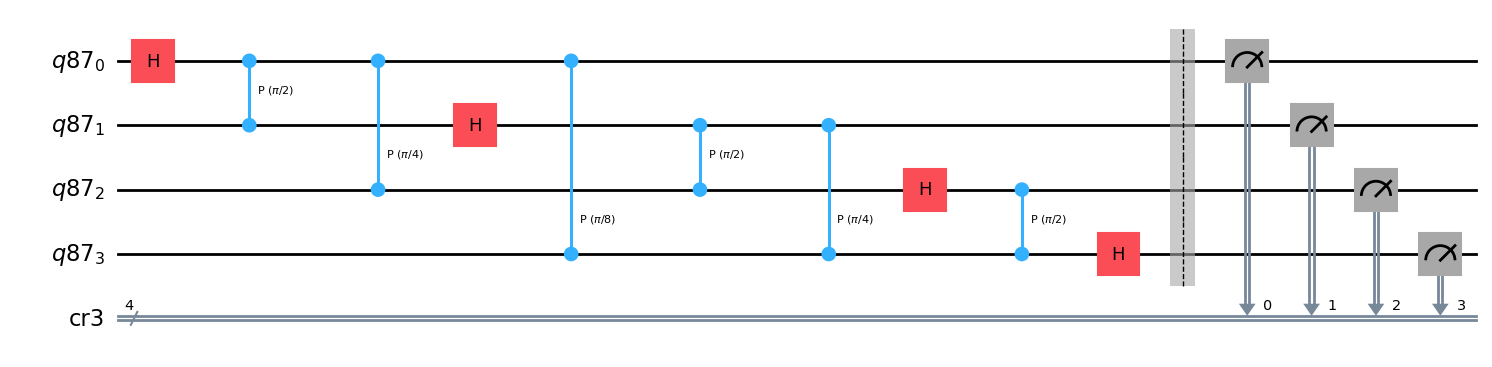

In [16]:
qc = get_qft_circuit_static_noswap(num_qubit=4)
qc.draw('mpl')

In [17]:
#QFT without swap dynamic circuit

In [18]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.classical import expr
from math import pi

def get_qft_circuit_dynamic_noswap(num_qubit):
    #Initialize the quantum circuit
    qr=QuantumRegister(num_qubit)
    cr1=ClassicalRegister(num_qubit,name="cr1")
    cr2=ClassicalRegister(num_qubit,name="cr2")
    qc=QuantumCircuit(qr,cr1,cr2)

    for j in range(num_qubit):
        qc.h(j)
        #Mid-circuit measurement
        qc.measure(qr[j],cr1[j])
        for k in range(j + 1, num_qubit):
            with qc.if_test((j, 1)):
                qc.p(pi / 2**(k - j), k)

    # Reverse the order of the qubits
    #for i in range(num_qubit // 2):
        #qc.swap(i, num_qubit - i - 1)

    qc.barrier()

    #Final measurement
    for i in range(num_qubit):
        qc.measure(qr[i],cr2[i])
    
    return qc

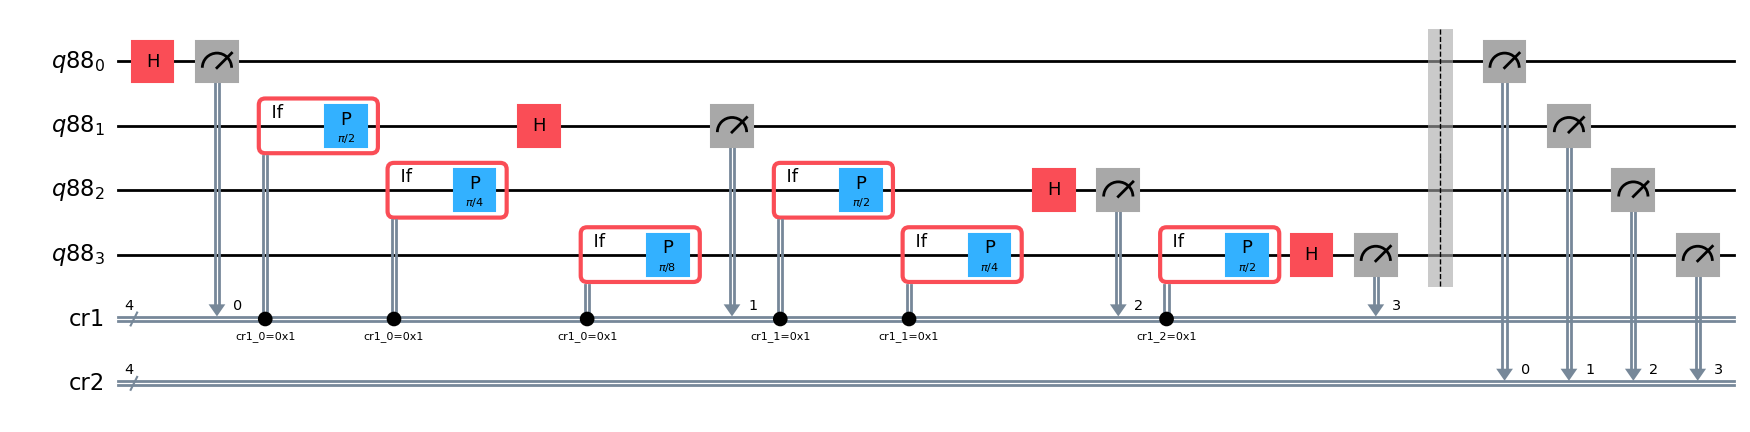

In [19]:
qc = get_qft_circuit_dynamic_noswap(num_qubit=4)
qc.draw('mpl')

In [20]:
#Creating list of circuits[Static_1, Dynamic_1, Static_1, Dynamic_1,...,Static_2, Dynamic_2, Static_2, Dynamic_2,...] i.e. some copies of each of them

min_qubit=3
max_num_qubit=16
copies=3

#qc_list_static=[]
#qc_list_dynamic=[]
#observables=[]

qc_list=[]
num_qubit_list=list(range(min_qubit,max_num_qubit+1))
for num_qubit in num_qubit_list:
    for i in range(copies):
        qc_list.append(get_qft_circuit_static_noswap(num_qubit))
        qc_list.append(get_qft_circuit_dynamic_noswap(num_qubit))
print(num_qubit_list)

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [21]:
#Ideal Simulation with AerSimulator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1, basis_gates=['snapshot', 'store', 'measure', 'barrier', 'h', 'cx'], translation_method='translator')
qc_transpiled_list=[]

qc_transpiled_list_ideal = pm.run(qc_list)

In [22]:
sampler = Sampler(backend=aer_sim)
result_ideal = sampler.run(qc_transpiled_list_ideal).result()

In [23]:
print(result_ideal)
len(result_ideal)

PrimitiveResult([PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>))), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))), PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>))), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))), PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>))), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))), PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=4>))), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=4>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=4>))), PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=4>))), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots

84

In [24]:
# For getting list of ideal counts (argument required for Fidelity)
counts_list_ideal=[]
for i in range(len(num_qubit_list)):  
    for j in range(copies):
        data_static_noswap = result_ideal[(2*i*copies)+(2*j)].data    
        data_dynamic_noswap = result_ideal[(2*i*copies)+((2*j)+1)].data 

        print(data_static_noswap)
        print(data_dynamic_noswap)
        
        counts_static_noswap=data_static_noswap.cr3.get_counts()
        counts_dynamic_noswap=data_dynamic_noswap.cr2.get_counts()
        
        counts_list_ideal.append(counts_static_noswap)
        counts_list_ideal.append(counts_dynamic_noswap)

DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=4>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=4>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=4>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=4>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=4>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=4>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=4>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, 

In [12]:
#Transpilation in real hardware

In [13]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(instance="ibm-q/open/main")
service.backends()

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibm_sherbrooke')>]

In [14]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.get_backend(backend_name)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled_list = pm.run(qc_list)

In [15]:
#Executing the circuit
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)
job = sampler.run(qc_transpiled_list,shots=1024)
print(job.job_id())

csxbzz7sgar0008d4b40


In [25]:
#Post-processing
import matplotlib.pyplot as plt
import statistics
from qiskit_ibm_runtime import QiskitRuntimeService

job_id = 'csxbzz7sgar0008d4b40' #Brisbane

service = QiskitRuntimeService()
job = service.job(job_id)
result_real = job.result()

In [26]:
print(result_real)
len(result_real)

PrimitiveResult([PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=4>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(

84

In [27]:
# For getting list of real counts of IBM brisbane (argument required for Fidelity)
counts_list_real=[]
for i in range(len(num_qubit_list)):  
    for j in range(copies):
        data_static_noswap = result_real[(2*i*copies)+(2*j)].data    
        data_dynamic_noswap = result_real[(2*i*copies)+((2*j)+1)].data 

        print(data_static_noswap)
        print(data_dynamic_noswap)
        
        counts_static_noswap=data_static_noswap.cr3.get_counts()
        counts_dynamic_noswap=data_dynamic_noswap.cr2.get_counts()
        
        counts_list_real.append(counts_static_noswap)
        counts_list_real.append(counts_dynamic_noswap)

DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=4>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=4>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=4>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=4>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=4>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=4>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=4>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, 

In [28]:
#Calculation of lists of Fidelity mean and std deviation of real hardware simulation in ibm_brisbane
import statistics
from qiskit.quantum_info.analysis import hellinger_fidelity
# We will create 4 lists of Fidelities, for storing mean, std deviation of Fidelity, of copies of a circuit for fixed no of logical qubits
 
Fidelity_mean_static_noswap_brisbane=[]
Fidelity_mean_dynamic_noswap_brisbane=[]

Fidelity_std_static_noswap_brisbane=[]
Fidelity_std_dynamic_noswap_brisbane=[]

Fidelity_copies_static_noswap_brisbane=[]
Fidelity_copies_dynamic_noswap_brisbane=[]

for i in range(len(num_qubit_list)):
    
    for j in range(copies):

        Fidelity_static_noswap= hellinger_fidelity(counts_list_ideal[(2*i*copies)+(2*j)], counts_list_real[(2*i*copies)+(2*j)])
        Fidelity_dynamic_noswap=hellinger_fidelity(counts_list_ideal[(2*i*copies)+((2*j)+1)], counts_list_real[(2*i*copies)+((2*j)+1)])

        Fidelity_copies_static_noswap_brisbane.append(Fidelity_static_noswap)
        Fidelity_copies_dynamic_noswap_brisbane.append(Fidelity_dynamic_noswap)

    
    Fidelity_mean_static_noswap_brisbane.append(statistics.mean(Fidelity_copies_static_noswap_brisbane))
    Fidelity_mean_dynamic_noswap_brisbane.append(statistics.mean(Fidelity_copies_dynamic_noswap_brisbane))
    
    Fidelity_std_static_noswap_brisbane.append(statistics.stdev(Fidelity_copies_static_noswap_brisbane))
    Fidelity_std_dynamic_noswap_brisbane.append(statistics.stdev(Fidelity_copies_dynamic_noswap_brisbane))
    
    Fidelity_copies_static_noswap_brisbane.clear()
    Fidelity_copies_dynamic_noswap_brisbane.clear()

[0.9787159754139398, 0.9631863654211458, 0.8715668096663423, 0.9018273070502022, 0.8022307611941824, 0.7907340171255297, 0.5185435796733304, 0.3098149622356972, 0.14772848809516448, 0.04627312132799432, 0.01159598770101319, 0.00357305243194545, 0.00116391097063466, 0.0003034569197058914]
[0.9875919040523529, 0.9631013075729867, 0.9531652385161342, 0.9197543687457289, 0.8833693421512252, 0.7604861152415989, 0.5579796399321251, 0.2927830026102184, 0.11986664048228954, 0.04209985134534661, 0.011332606068934381, 0.0034280535715274243, 0.0007353545496446082, 0.0003351011546420601]


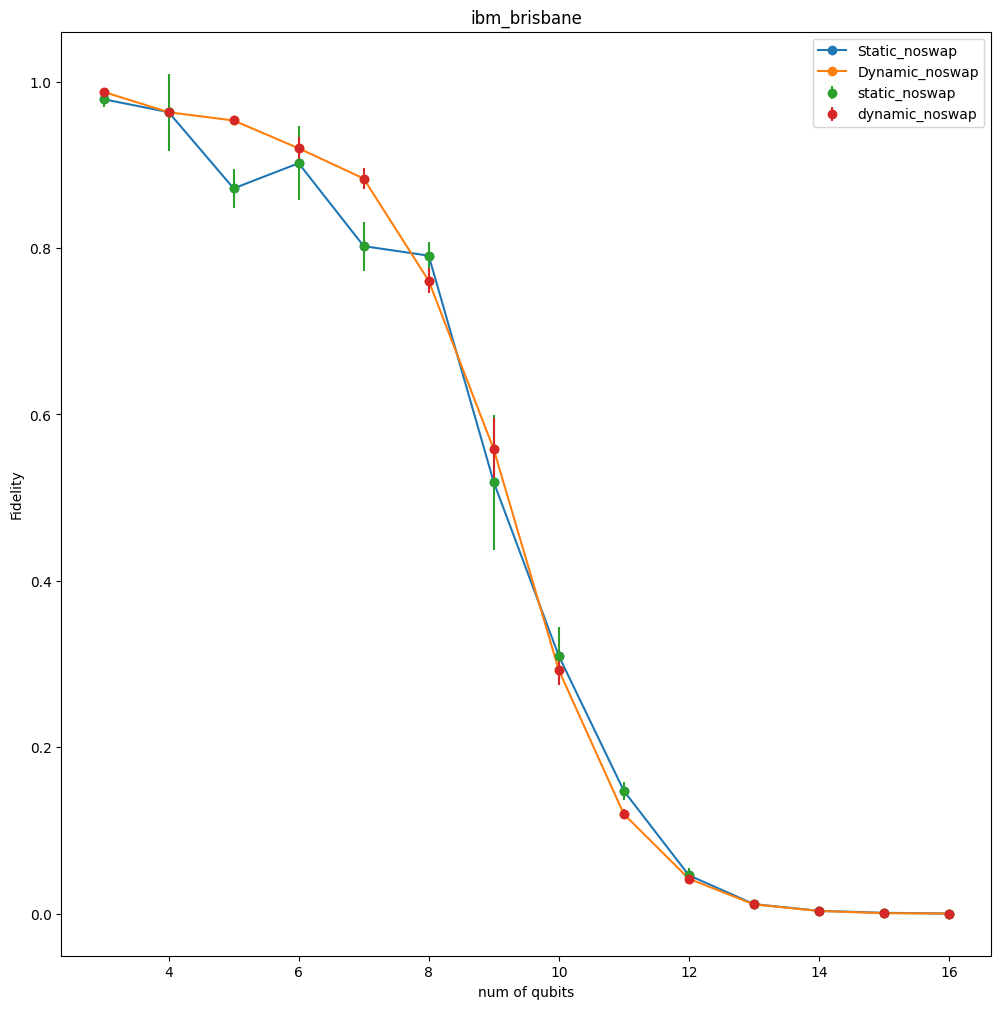

In [29]:
# Graph plotting
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
#figure(figsize=(16,12), dpi=180)
fig, ax1 = plt.subplots(1, 1, figsize=(12,12))

# Create  data.
ax1.set_xlabel('num of qubits')
ax1.set_ylabel('Fidelity')
ax1.set_title('ibm_brisbane')
x1 = num_qubit_list
y1_static_noswap = Fidelity_mean_static_noswap_brisbane
y1_dynamic_noswap = Fidelity_mean_dynamic_noswap_brisbane
print(y1_static_noswap)
print(y1_dynamic_noswap)
y_error_static_noswap =Fidelity_std_static_noswap_brisbane
y_error_dynamic_noswap =Fidelity_std_dynamic_noswap_brisbane
ax1.plot(x1, y1_static_noswap, 'o-',label='Static_noswap')
ax1.plot(x1, y1_dynamic_noswap, 'o-',label='Dynamic_noswap')
ax1.errorbar(x1, y1_static_noswap,
			yerr = y_error_static_noswap, label='static_noswap',
			fmt ='o')
ax1.errorbar(x1, y1_dynamic_noswap,
			yerr = y_error_dynamic_noswap, label='dynamic_noswap',
			fmt ='o')


plt.legend()
plt.show()